# Normal model for basketball scores (using MCMC sampling)

In [1]:
import pandas as pd, numpy as np, scipy as sp, matplotlib.pyplot as plt, pymc3 as pm
from scipy import stats
from sklearn.preprocessing import StandardScaler
import plot_tools

In [2]:
bball = pd.read_csv('data/basketball.csv')
bball.head()
modern = bball[bball['Year'] > 1960]

In [3]:
# Get some subsamples
modern_era = bball[bball['Year']>=1987]
sample_small = modern_era.iloc[np.random.choice(len(modern_era), 10)]    # 10 games
sample_med = modern_era.iloc[np.random.choice(len(modern_era), 40)]    # 40 games
sample_large = modern_era.iloc[np.random.choice(len(modern_era), 100)]    # 100 games

mean_small = sample_small['Combined'].mean()
mean_med = sample_med['Combined'].mean()
mean_large = sample_large['Combined'].mean()

sd_small = sample_small['Combined'].std()
sd_med = sample_small['Combined'].std()
sd_large = sample_small['Combined'].std()

### Known variance case

In [13]:
with pm.Model() as normal_model_known:
    # Priors for parameters
    mean = pm.Normal('mu', mu=200, sigma=100)
    
    # Likelihood
    score = pm.Normal('score', mu = mean, sigma = 24, observed = sample_large['Combined'])
    
    # Inference
    trace = pm.sample(2000, target_accept = 0.9, tune = 1000)
    summary = pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2600.27draws/s]


(array([   7.,   54.,  205.,  550.,  926., 1052.,  747.,  344.,   95.,
          20.]),
 array([138.511146  , 140.12944019, 141.74773438, 143.36602857,
        144.98432277, 146.60261696, 148.22091115, 149.83920534,
        151.45749954, 153.07579373, 154.69408792]),
 <BarContainer object of 10 artists>)

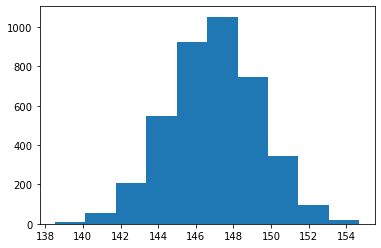

In [9]:
plt.hist(trace['mu'])

In [14]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,147.011,2.402,142.143,151.294,0.06,0.042,1610.0,1609.0,1605.0,2427.0,1.0


### Unknown variance

In [15]:
with pm.Model() as normal_model_unknown:
    # Priors for parameters
    mu = pm.Flat('mu')
    sigma_log = pm.Flat('sigma_log')
    sigma = pm.Deterministic('sigma', pm.math.exp(sigma_log))
    #sigma = pm.math.exp(sigma_log)
    
    # Likelihood
    score = pm.Normal('score', mu = mu, sigma = sigma, observed = sample_small['Combined'])
    
    # Inference
    trace = pm.sample(2000, target_accept = 0.9, tune = 1000)
    summary = pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:03<00:00, 1728.16draws/s]


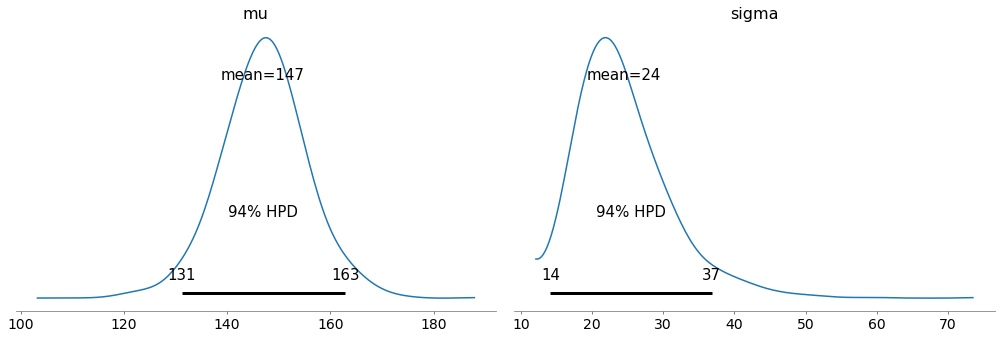

In [17]:
with normal_model_unknown:
    pm.plot_posterior(trace, var_names=['mu', 'sigma'])

In [18]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,146.949,8.244,131.193,162.900,0.188,0.134,1918.0,1902.0,2062.0,1652.0,1.0
sigma_log,3.164,0.249,2.707,3.644,0.006,0.004,1856.0,1814.0,1945.0,1885.0,1.0
sigma,24.444,6.598,14.125,36.799,0.159,0.114,1720.0,1665.0,1945.0,1885.0,1.0


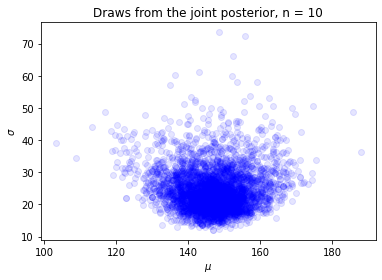

In [19]:
plt.figure()
plt.plot(trace['mu'][:4000], trace['sigma'][:4000], 'o', color = 'blue', alpha = 0.1)
plt.title('Draws from the joint posterior, n = 10')
#plt.xlim(100, 200)
#plt.ylim(20, 50)
plt.xlabel('$\\mu$')
plt.ylabel('$\\sigma$')
plt.show()

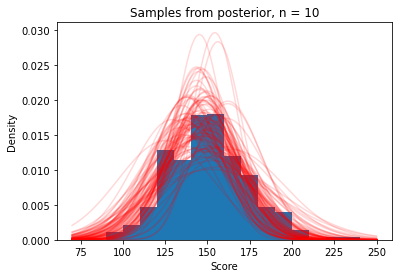

In [20]:
plt.figure()
plt.hist(modern_era['Combined'], density = True, bins = range(70, 250, 10))
x = np.linspace(70, 250, 5000)
for i in range(100):
    y = sp.stats.norm.pdf(x, trace['mu'][i], trace['sigma'][i])
    plt.plot(x, y, color = 'red', alpha = 0.15)

plt.title('Samples from posterior, n = 10')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

## Posterior predictive checking

In [ ]:
with normal_model:
    replications = pm.sample_posterior_predictive(trace)

In [ ]:
replications['score'].shape

In [ ]:
# plot them along with the real data set in random order subplot
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 12))
fig.subplots_adjust(top=0.95, wspace=0.4)
np.random.seed(824792)
order = np.random.permutation(10)
choices = np.random.permutation(10000)
for i, ax in enumerate(axes.flat):
    ax.hist(
        replications['score'][choices[i]] if order[i] < 9 else sample_large['Combined'],
        np.arange(50, 250, 5),
        #color = 'blue' if order[i] < 9 else 'red'
        color = 'blue'
    )
    plot_tools.modify_axes.only_x(ax)
axes[0, 0].set_xlim([50, 250])
fig.suptitle(
    "Basketball example: Observed data + Replicated datasets.\n"
    "Can you spot which one is the observed data?"
);

In [ ]:
mins = np.min(rep['score'], axis = 1)
maxs = np.max(rep['score'], axis = 1)

In [ ]:
plt.hist(mins)
plt.ylim((0, 750))
plt.vlines(x=modern['Combined'].min(), ymin=0, ymax=750, color = 'red')

In [ ]:
plt.hist(maxs)
plt.ylim((0, 750))
plt.vlines(x=modern['Combined'].max(), ymin=0, ymax=750, color = 'red')

In [ ]:
modern['Combined'].sort_values()

In [ ]:
modern.loc[1370]